# Bottlecap Sorter - Model Development & Experimentation

This notebook contains the step-by-step approach to solve the bottlecap detection problem.

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path
import shutil
import random
import cv2

# Setup matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Define paths
DATASET_DIR = Path('../dataset')
SAMPLE_DIR = DATASET_DIR / 'sample'
PROCESSED_DIR = DATASET_DIR / 'processed'

# Create processed directory if it doesn't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Dataset Directory: {DATASET_DIR}")
print(f"Sample Directory: {SAMPLE_DIR}")

Dataset Directory: ../dataset
Sample Directory: ../dataset/sample


## 2. Data Loading & Visualization

We need to load images and their corresponding labels. The labels are in YOLO format:
`<class_id> <x_center> <y_center> <width> <height>` (normalized 0-1)

Loaded raw-250110_dc_s001_b2_3.jpg
Labels: [[0, 0.368569, 0.124068, 0.083712, 0.066232], [0, 0.637956, 0.163347, 0.083212, 0.064429], [0, 0.561556, 0.87274, 0.082888, 0.066764], [0, 0.445731, 0.629018, 0.077262, 0.057655], [0, 0.237806, 0.47514, 0.105938, 0.083527], [0, 0.33355, 0.746959, 0.08285, 0.062295], [0, 0.416162, 0.237465, 0.0768, 0.057515]]


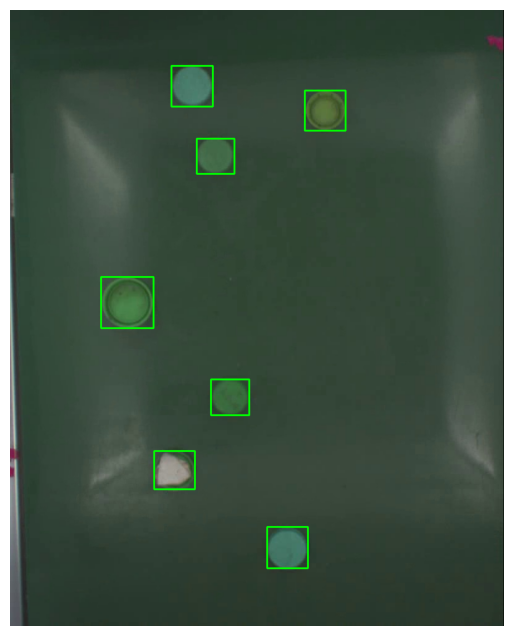

In [2]:
def load_image(path):
    """Load an image from path and convert to RGB."""
    img = cv2.imread(str(path))
    if img is None:
        raise ValueError(f"Could not load image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_label(path):
    """Load YOLO labels from text file."""
    labels = []
    if not path.exists():
        return labels
    
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                # class_id, x_center, y_center, width, height
                labels.append([int(parts[0])] + [float(x) for x in parts[1:]])
    return labels

def draw_bbox(image, labels, class_names=None):
    """Draw bounding boxes on the image."""
    img_h, img_w = image.shape[:2]
    img_vis = image.copy()
    
    for label in labels:
        cls_id, xc, yc, w, h = label
        
        # Convert normalized coordinates to pixel coordinates
        x1 = int((xc - w/2) * img_w)
        y1 = int((yc - h/2) * img_h)
        x2 = int((xc + w/2) * img_w)
        y2 = int((yc + h/2) * img_h)
        
        # Color based on class ID (just for visualization)
        color = (0, 255, 0)
        if cls_id == 1: color = (0, 0, 255)
        if cls_id == 2: color = (255, 0, 0)
            
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), color, 2)
        
        if class_names:
            text = class_names.get(cls_id, str(cls_id))
            cv2.putText(img_vis, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
    return img_vis

# Test on a sample image
sample_images = list(SAMPLE_DIR.glob('*.jpg'))
if sample_images:
    img_path = sample_images[0]
    label_path = img_path.with_suffix('.txt')
    
    img = load_image(img_path)
    labels = load_label(label_path)
    
    print(f"Loaded {img_path.name}")
    print(f"Labels: {labels}")
    
    vis_img = draw_bbox(img, labels)
    plt.imshow(vis_img)
    plt.axis('off')
    plt.show()
else:
    print("No sample images found.")

## 3. Color Detection & Re-labeling

We need to distinguish between:
- **Light Blue** (Class 0)
- **Dark Blue** (Class 1)
- **Others** (Class 2)

We will use HSV color space for this.

In [3]:
def get_color_class(roi_rgb):
    """
    Determine the color class of the ROI.
    Returns:
        0: Light Blue
        1: Dark Blue
        2: Others
    """
    # Convert to HSV
    hsv = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2HSV)
    
    # Define HSV ranges
    # Note: These ranges might need tuning based on the dataset
    
    # Light Blue
    # H: 90-110 (approx), S: > 50, V: > 50
    lb_lower = np.array([90, 50, 50])
    lb_upper = np.array([105, 255, 255])
    
    # Dark Blue
    # H: 110-130 (approx), S: > 50, V: < 200 (maybe darker?)
    db_lower = np.array([105, 50, 30])
    db_upper = np.array([135, 255, 255])
    
    # Create masks
    mask_lb = cv2.inRange(hsv, lb_lower, lb_upper)
    mask_db = cv2.inRange(hsv, db_lower, db_upper)
    
    # Calculate coverage
    total_pixels = roi_rgb.shape[0] * roi_rgb.shape[1]
    lb_coverage = np.count_nonzero(mask_lb) / total_pixels
    db_coverage = np.count_nonzero(mask_db) / total_pixels
    
    # Threshold for classification
    coverage_threshold = 0.3  # at least 30% of the ROI should match
    
    if lb_coverage > coverage_threshold and lb_coverage > db_coverage:
        return 0  # Light Blue
    elif db_coverage > coverage_threshold:
        return 1  # Dark Blue
    else:
        return 2  # Others

def process_dataset(source_dir, dest_dir):
    """Process all images in source_dir, relabel, and save to dest_dir."""
    source_path = Path(source_dir)
    dest_path = Path(dest_dir)
    dest_path.mkdir(parents=True, exist_ok=True)
    
    images = list(source_path.glob('*.jpg'))
    print(f"Processing {len(images)} images...")
    
    class_counts = {0: 0, 1: 0, 2: 0}
    
    for img_path in images:
        # Load image and labels
        img = load_image(img_path)
        label_path = img_path.with_suffix('.txt')
        labels = load_label(label_path)
        
        new_labels = []
        img_h, img_w = img.shape[:2]
        
        for label in labels:
            cls_id, xc, yc, w, h = label
            
            # Extract ROI
            x1 = int((xc - w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            x2 = int((xc + w/2) * img_w)
            y2 = int((yc + h/2) * img_h)
            
            # Clamp coordinates
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_w, x2), min(img_h, y2)
            
            roi = img[y1:y2, x1:x2]
            
            if roi.size == 0:
                continue
                
            # Determine new class
            new_cls_id = get_color_class(roi)
            class_counts[new_cls_id] += 1
            
            new_labels.append([new_cls_id, xc, yc, w, h])
            
        # Save new labels
        new_label_path = dest_path / label_path.name
        with open(new_label_path, 'w') as f:
            for l in new_labels:
                f.write(f"{l[0]} {l[1]:.6f} {l[2]:.6f} {l[3]:.6f} {l[4]:.6f}\n")
                
        # Copy image
        shutil.copy(img_path, dest_path / img_path.name)
        
    print("Processing complete.")
    print(f"Class counts: {class_counts}")

# Run processing on sample data
process_dataset(SAMPLE_DIR, PROCESSED_DIR)

Processing 12 images...
Processing complete.
Class counts: {0: 15, 1: 17, 2: 47}


## 4. Verification

Let's visualize some processed images to verify the new labels.

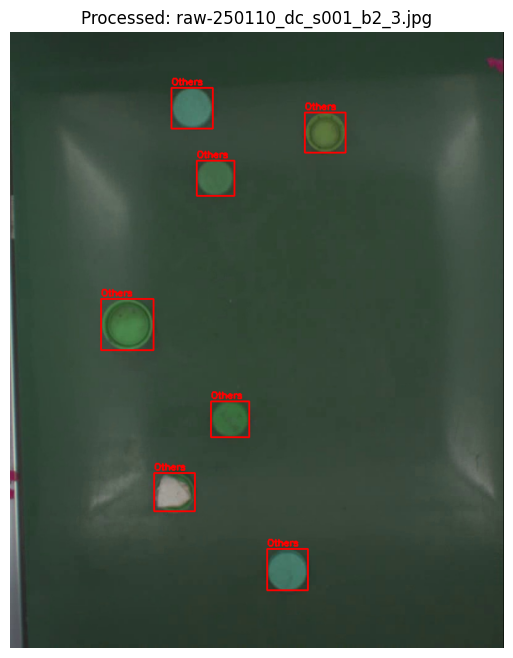

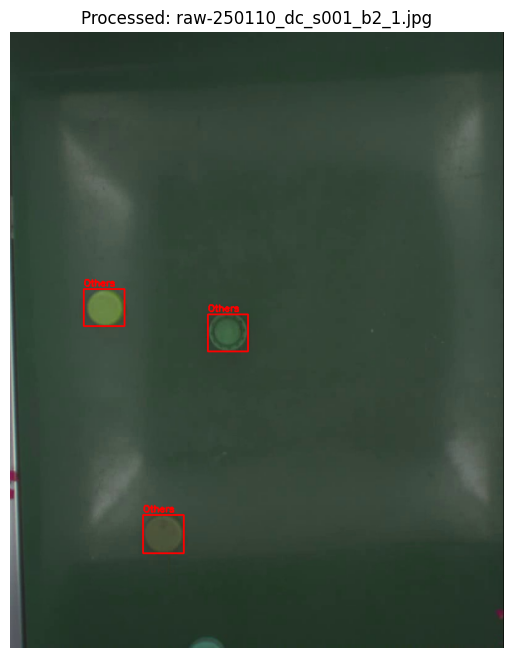

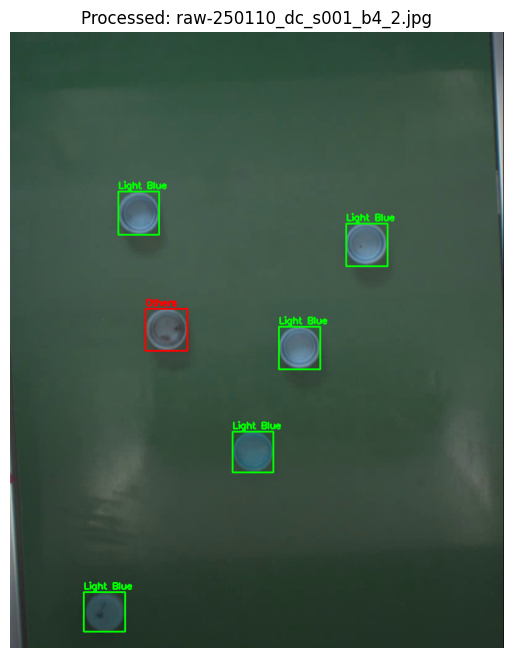

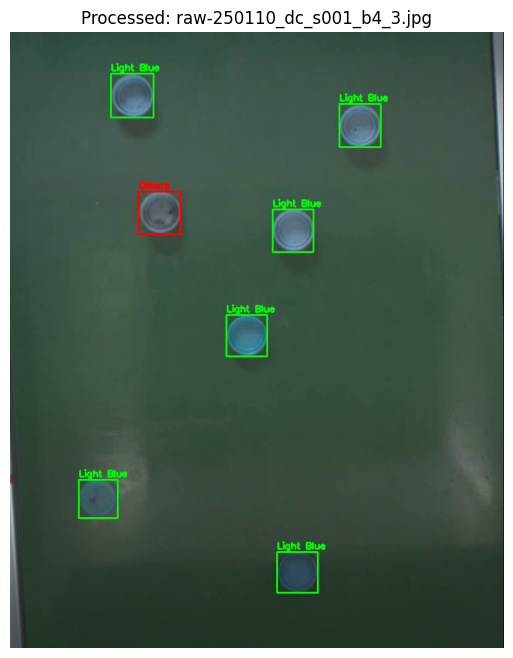

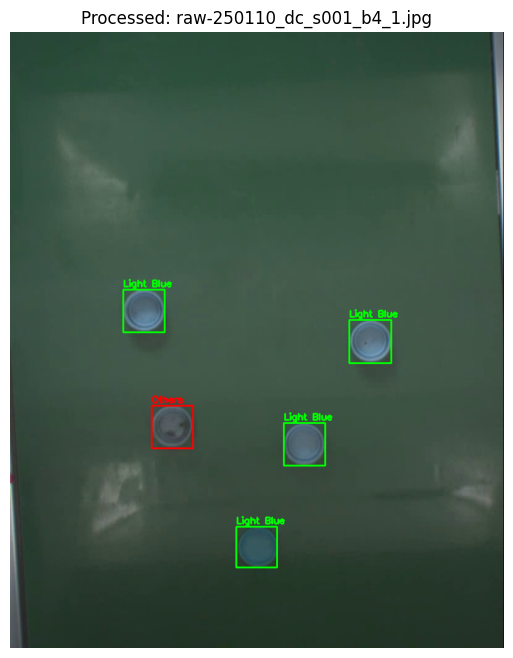

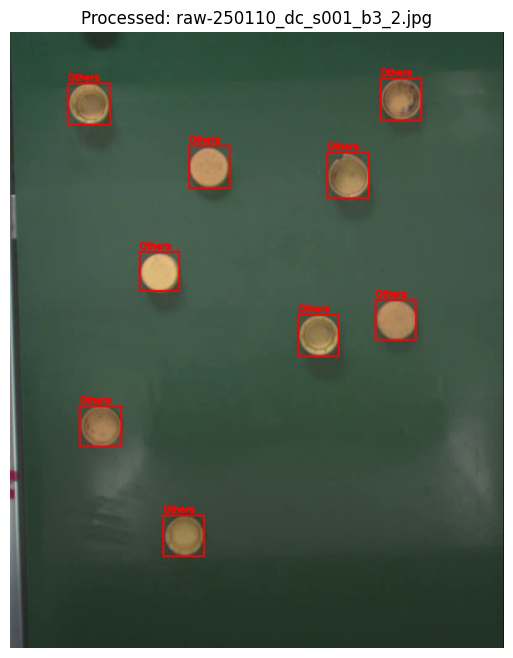

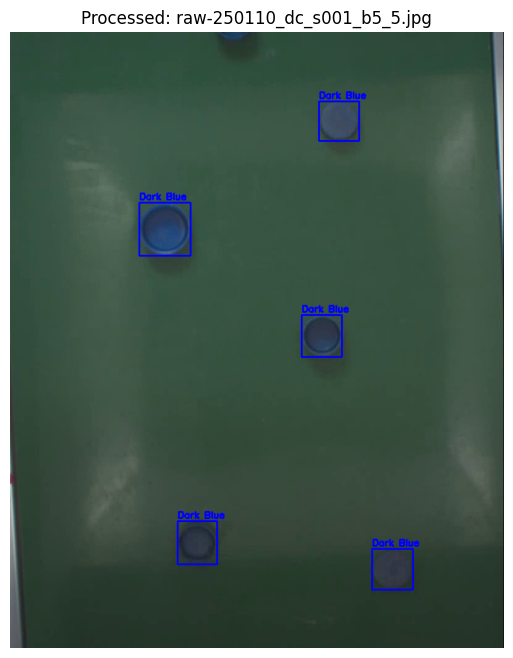

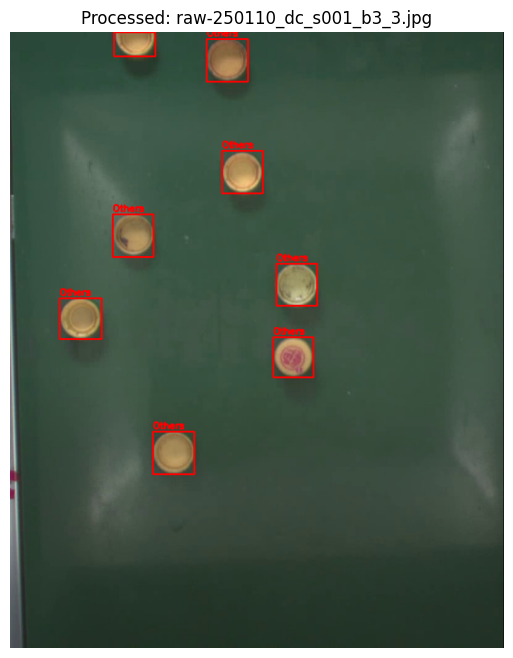

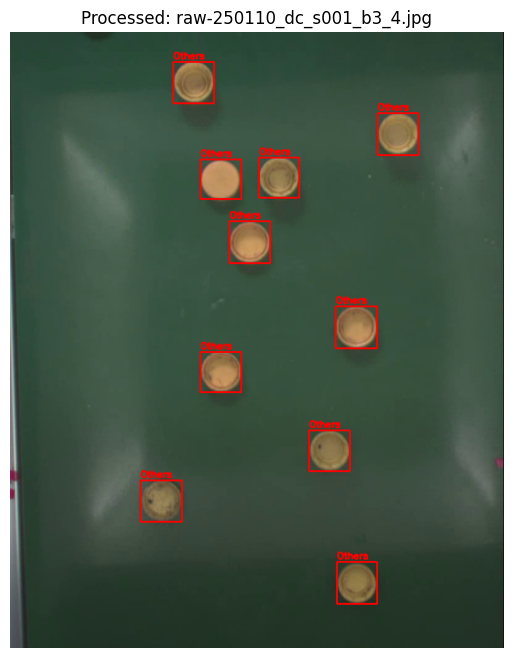

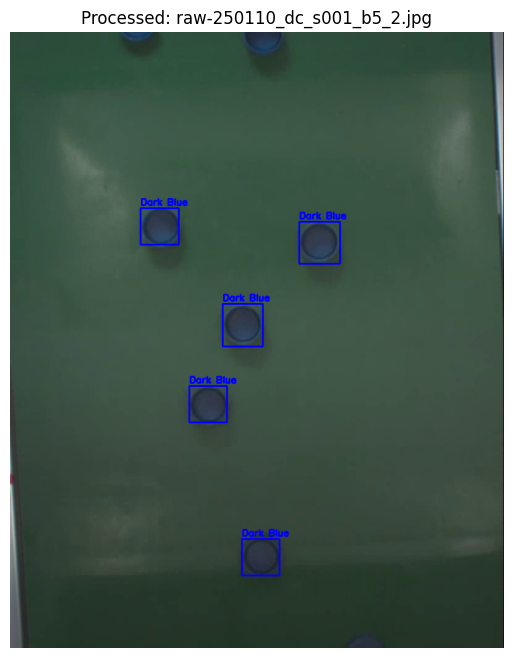

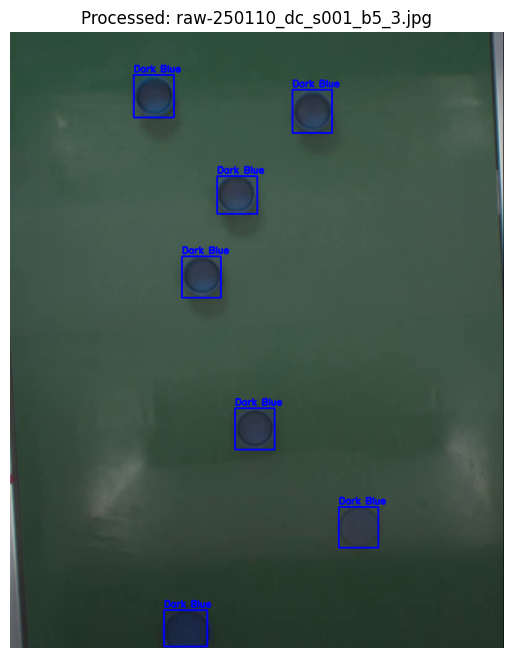

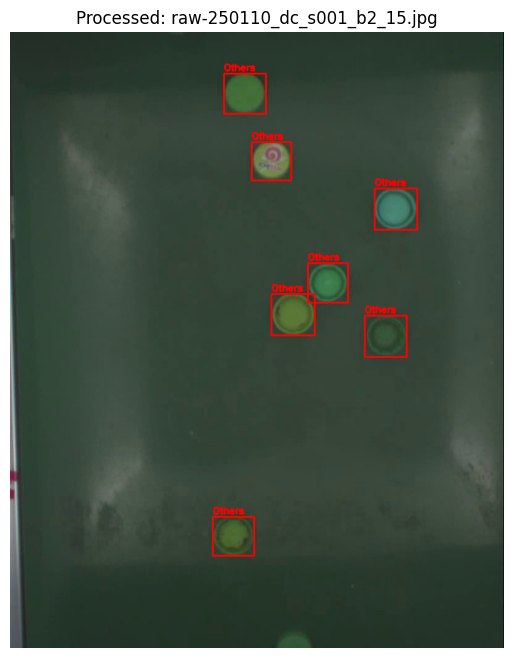

In [4]:
processed_images = list(PROCESSED_DIR.glob('*.jpg'))
if processed_images:
    class_names = {0: 'Light Blue', 1: 'Dark Blue', 2: 'Others'}
    
    for img_path in processed_images:
        label_path = img_path.with_suffix('.txt')
        
        img = load_image(img_path)
        labels = load_label(label_path)
        
        vis_img = draw_bbox(img, labels, class_names)
        plt.figure()
        plt.imshow(vis_img)
        plt.title(f"Processed: {img_path.name}")
        plt.axis('off')
        plt.show()
else:
    print("No processed images found.")

## 4. Model Training & Evaluation

We will now evaluate the performance of our color-based classifier.
1. Split the dataset into **Training** and **Validation** sets (80/20).
2. Evaluate the heuristic model on the Validation set.
3. Calculate **Accuracy**, **Confusion Matrix**, and **Classification Report**.

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get all processed images
all_images = list(PROCESSED_DIR.glob('*.jpg'))

# Split into Train and Validation sets
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Total images: {len(all_images)}")
print(f"Training set: {len(train_files)}")
print(f"Validation set: {len(val_files)}")

In [ ]:
def evaluate_model(image_paths):
    y_true = []
    y_pred = []
    
    print(f"Evaluating on {len(image_paths)} images...")
    
    for img_path in image_paths:
        # Load image
        img = load_image(img_path)
        
        # Load Ground Truth Labels (from the processed folder, assuming they are correct/corrected)
        label_path = img_path.with_suffix('.txt')
        if not label_path.exists():
            continue
            
        gt_labels = load_label(label_path)
        
        # For each object in the ground truth
        img_h, img_w = img.shape[:2]
        
        for label in gt_labels:
            cls_id, xc, yc, w, h = label
            
            # Extract ROI
            x1 = int((xc - w/2) * img_w)
            y1 = int((yc - h/2) * img_h)
            x2 = int((xc + w/2) * img_w)
            y2 = int((yc + h/2) * img_h)
            
            # Clip to image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_w, x2), min(img_h, y2)
            
            if x1 >= x2 or y1 >= y2:
                continue
                
            roi = img[y1:y2, x1:x2]
            
            # Predict using our heuristic function
            pred_cls = get_color_class(roi)
            
            y_true.append(cls_id)
            y_pred.append(pred_cls)
            
    return y_true, y_pred

# Run Evaluation
y_true, y_pred = evaluate_model(val_files)

# Metrics
if y_true:
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nClassification Report:")
    target_names = ['Light Blue', 'Dark Blue', 'Others']
    # Use labels=[0, 1, 2] to ensure all classes are reported even if missing in val set
    print(classification_report(y_true, y_pred, labels=[0, 1, 2], target_names=target_names))
else:
    print("No objects found in validation set.")